In [1]:
import os
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from time import time
from torch import nn, optim
from sklearn.datasets import make_regression

%matplotlib inline

root_random = 50
np.random.seed(root_random)

# Section 1

- Becoming familiar with tensor based operations and generating synthetic data.
- Are input features uninformative? Are the hyper-parameters set correctly? Is there an inherent bug?
- Test by passing data with known correct distribution and compare correctness

# Problem
- This task is a regression task
- Use Tensors on Synthetic data I produce
- Come up with a mapping function from Rm to Rn, where m and n are set and both are > 3.
- Provide the equation of the functions
- Add random noise to the output to make the problem more interesting
- Ensure underlying function is still recognisable
- Be careful of expected value of noise
- Pass data to the algorithm to test the output model

# Notes
- Do not use regression libraries. Must all be implemented using tensors.
- Avoid using loops where tensor operations could act on multiple values at once.
- Avoid using matrix inverse operators. Use gradients instead.
- Be mindful of gradient tracking.
- Be sure to generate enough data.
- Choose appropriate learning rate
- Choose appropriate learning termination criteria.

In [2]:
#Produce Synthetic Data
#Functions 
#Target (R5) = Input (R4)
#Y1 = X1
#Y2 = 2*(X2 - X1)
#Y3 = X2/(X1 - X4)
#Y4 = X3 + X4 - X1
#Y5 = X4 - X2 * X3

def generate_synthetic_data():
    #Generate data
    dataset = 10*np.random.random_sample((20, 4))
    return dataset

def add_noise(data):
    adding = np.random.random_sample((20, 4))-0.5
    out = np.add(data, adding)
            
    return out

dataset = generate_synthetic_data()
results = np.zeros((20, 5))
for i in range(20):
    for j in range(5):
        if j == 0:
            results[i][j] = dataset[i][0]
        elif j == 1:
            results[i][j] = 2 * (dataset[i][1] - dataset[i][0])
        elif j == 2:
            results[i][j] = dataset[i][1]/(dataset[i][0] - dataset[i][3])
        elif j == 3:
            results[i][j] = dataset[i][2] + dataset[i][3] - dataset[i][0]
        elif j == 4:
            results[i][j] = dataset[i][3] - dataset[i][1] * dataset[i][2]
        
noisey_dataset = add_noise(dataset)
noisey_results = np.zeros((20, 5))
for i in range(20):
    for j in range(5):
        if j == 0:
            noisey_results[i][j] = noisey_dataset[i][0]
        elif j == 1:
            noisey_results[i][j] = 2 * (noisey_dataset[i][1] - noisey_dataset[i][0])
        elif j == 2:
            noisey_results[i][j] = noisey_dataset[i][1]/(noisey_dataset[i][0] - noisey_dataset[i][3])
        elif j == 3:
            noisey_results[i][j] = noisey_dataset[i][2] + noisey_dataset[i][3] - noisey_dataset[i][0]
        elif j == 4:
            noisey_results[i][j] = noisey_dataset[i][3] - noisey_dataset[i][1] * noisey_dataset[i][2]

#Convert to tensors
inputs = torch.from_numpy(noisey_dataset)
targets = torch.from_numpy(noisey_results)
actual_model = torch.from_numpy(results)
print(inputs)

#Tensors now ready

tensor([[ 4.4599,  2.3697,  2.4377,  3.5781],
        [ 4.1376, 10.2874,  4.3195,  8.0593],
        [ 7.5069,  3.3487,  3.5250,  3.6309],
        [ 1.2528,  9.8290,  9.0175,  5.6381],
        [ 3.1226,  8.8819,  7.1632,  3.6738],
        [ 4.6215,  5.2037,  9.1882,  5.7008],
        [ 6.2539,  0.6047,  3.7576,  0.2731],
        [ 1.5107,  9.7205,  9.5871,  7.2339],
        [ 7.2077,  4.7562,  9.3157,  3.6540],
        [ 6.6292,  6.8273,  5.6631,  2.6249],
        [ 6.9119,  8.2971,  7.8372,  3.8622],
        [ 8.8061,  7.4976,  6.9240,  1.6322],
        [ 9.5690,  3.6125,  2.8566,  6.1385],
        [ 5.0087,  2.3454,  8.0638,  1.7443],
        [ 2.6736,  6.6937,  4.7038,  0.6401],
        [ 1.1981,  0.9410,  4.6929,  5.5411],
        [ 9.8760,  5.3750,  5.5012,  9.4952],
        [ 8.9370,  3.0052,  7.0013, 10.0355],
        [ 2.0127,  6.7119,  8.1873,  9.8248],
        [ 8.0601,  4.6286,  0.2827,  0.8041]], dtype=torch.float64)


In [3]:
#Regression Model

#Weights and Biases
weight = torch.rand(5, 4, requires_grad=True)
bias = torch.rand(5, requires_grad=True)

print(weight)

#Model
def model(val):
    return val @ (weight.t()).double() + bias.double()

preds = model(inputs)
#print(preds)
#print(targets)

tensor([[0.7736, 0.9039, 0.1918, 0.7906],
        [0.4228, 0.3274, 0.1716, 0.2821],
        [0.8843, 0.9520, 0.9500, 0.5755],
        [0.5307, 0.9366, 0.2495, 0.4863],
        [0.1098, 0.8046, 0.1385, 0.9163]], requires_grad=True)


In [4]:
#Loss calculations

#Mean square error loss function
def mse(pred, target):
    diff = pred - target
    return torch.sum(diff * diff) / diff.numel()

#Calc loss
loss = mse(preds, targets)
print(loss)

#Compute gradient
loss.backward()

# Train for 100 epochs
for i in range(100):  
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        weight -= weight.grad * 1e-2
        bias -= bias.grad * 1e-2
        weight.grad.zero_()
        bias.grad.zero_()

        if (i+1)%10==0:
            print(loss)

tensor(675.0820, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(62.2016, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(36.0931, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(25.2705, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(20.5874, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(18.4492, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(17.4098, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(16.8691, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(16.5675, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(16.3871, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(16.2715, dtype=torch.float64, grad_fn=<DivBackward0>)


# Section 2

- Small scale transfer learning
- Train a CNN on a simple problem and try to transfer the learning to ma larger and more difficult problem
- USE NN OPTIMISATION FROM pytorch

# Problem
- Define two network classes
    - torchvision.datasets.MNIST
    - torchvision.datasets.CIFAR10
- Train first network to a good performance
- Train second network to observe losses over time (epochs)
- Test to see if copying layers from MNIST to CIFAR10 (before training) improves training of the second network.

# Notes
- Which layers are good to be transfered? (all but last 2?)
- How to deal with differing dimensionality?
- How to copy objects across?
- Presenting findings coherently
- Based on https://medium.com/dsnet/training-deep-neural-networks-on-a-gpu-with-pytorch-11079d89805
- Model from https://github.com/pytorch/examples/blob/master/mnist/main.py

# Section 3

- Option A Cost Sensitive Learning

# Problem
- C is a k-by-k cost matrix for a classification class with k classes
- the element C(i,j) is the cost of classifying an instance of class j as class i
- Want to minimise the expected cost of predictions

- Write Psuedocode that, when optomised, achieves minimum expected cost of prediction
- Assuming a learning algorithm which minimises cost prediction is given, write a different way of achieving minimum expected cost prediction


# Notes
- Consider cases with k > 1 and briely discuss scalability.
- Do not have to use tensors
- Can write in pseudo-Python

In [5]:
DOWNLOAD=False

if not(os.path.exists('./data')) or not os.listdir('./data'):
    DOWNLOAD=True

#Set download=True if MNIST not yet downloaded
train_data = MNIST('./data', download=DOWNLOAD, train=True, transform=ToTensor())
test_data = MNIST('./data', download=DOWNLOAD, train=False, transform=ToTensor())
trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
valloader = DataLoader(test_data, batch_size=100, shuffle=True)

print(len(train_data))
print(len(test_data))

60000
10000


In [25]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.linear1 = nn.Linear(16*50, 500)
        self.linear2 = nn.Linear(500, 10)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = F.relu(self.conv1(xb))
        xb = F.max_pool2d(xb, 2, 2)
        xb = F.relu(self.conv2(xb))
        xb = F.max_pool2d(xb, 2, 2)
        xb = xb.view(-1, 4*4*50)
        # Get intermediate outputs using hidden layer
        xb = self.linear1(xb)
        # Apply activation function
        xb = F.relu(xb)
        # Get predictions using output layer
        xb = self.linear2(xb)
        return xb
input_size = 784
num_classes = 10

model = MnistModel()
for t in model.parameters():
    print(t.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

for images, labels in trainloader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


In [27]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

trainloader = DeviceDataLoader(trainloader, device)
valloader = DeviceDataLoader(valloader, device)


for xb, yb in valloader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([9, 1, 0, 8, 5, 8, 0, 5, 9, 2, 3, 1, 7, 8, 1, 7, 5, 7, 4, 9, 6, 2, 3, 3,
        8, 2, 9, 4, 8, 5, 1, 6, 7, 1, 4, 7, 7, 5, 6, 1, 2, 4, 2, 0, 8, 4, 0, 8,
        3, 4, 4, 6, 8, 2, 7, 0, 2, 6, 8, 5, 7, 5, 4, 3, 4, 5, 9, 8, 2, 0, 7, 9,
        8, 9, 8, 1, 0, 2, 7, 6, 9, 1, 8, 8, 7, 9, 7, 8, 0, 5, 2, 5, 0, 3, 4, 2,
        7, 9, 8, 9])


In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)
                     
    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters             
        opt.step()
        # Reset gradients
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

def evaluate(model, loss_fn, valloader, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valloader]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches 
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

def fit(epochs, lr, model, loss_fn, train_dl, 
        valid_dl, metric=None, opt_fn=None):
    losses, metrics = [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        losses.append(val_loss)
        metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, 
                          metric.__name__, val_metric))
    return losses, metrics

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

# Model (on GPU)
model = MnistModel()
to_device(model, device)

MnistModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=800, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
)

In [29]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, 
                                    valloader, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3084, Accuracy: 0.0413


In [30]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, 
                        trainloader, valloader, accuracy)

Epoch [1/5], Loss: 0.0685, accuracy: 0.9784
Epoch [2/5], Loss: 0.0439, accuracy: 0.9857
Epoch [3/5], Loss: 0.0361, accuracy: 0.9878
Epoch [4/5], Loss: 0.0445, accuracy: 0.9866
Epoch [5/5], Loss: 0.0345, accuracy: 0.9892


In [31]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy, 
                        trainloader, valloader, accuracy)

Epoch [1/5], Loss: 0.0287, accuracy: 0.9917
Epoch [2/5], Loss: 0.0296, accuracy: 0.9915
Epoch [3/5], Loss: 0.0297, accuracy: 0.9918
Epoch [4/5], Loss: 0.0318, accuracy: 0.9910
Epoch [5/5], Loss: 0.0317, accuracy: 0.9914


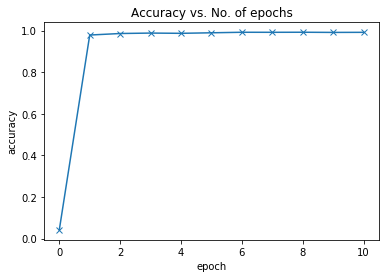

In [32]:
# Replace these values with your results
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');